In [42]:
import pandas as pd
import numpy as np
from scipy import signal
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.style.use('ggplot') #グラフのスタイル
plt.rcParams['figure.figsize'] = [12, 9] 
from statsmodels.tsa.vector_ar.var_model import VAR

from graphviz import Digraph

In [43]:
estimate_from_mobile_data = np.load('/home/is/shuntaro-o/dev/persons_move_analysis/data/array_population_number_estimate/estimate_from_mobile_data.npy')
estimate_month7_Geo = np.load('/home/is/shuntaro-o/dev/persons_move_analysis/data/array_population_number_estimate/estimate_month7_Geo.npy')

In [44]:
estimate_from_mobile_data_flatten = estimate_from_mobile_data.flatten()
estimate_month7_Geo_flatten = estimate_month7_Geo.flatten()

In [45]:
columns_mobile = ['population_mobile']
columns_Geo = ['population_Geo']
df_mobile = pd.DataFrame(data=estimate_from_mobile_data_flatten, columns=columns_mobile, dtype='float')
df_Geo = pd.DataFrame(data=estimate_month7_Geo_flatten , columns=columns_Geo, dtype='float')

In [46]:
df = pd.concat([df_mobile,df_Geo],axis=1)

<AxesSubplot: >

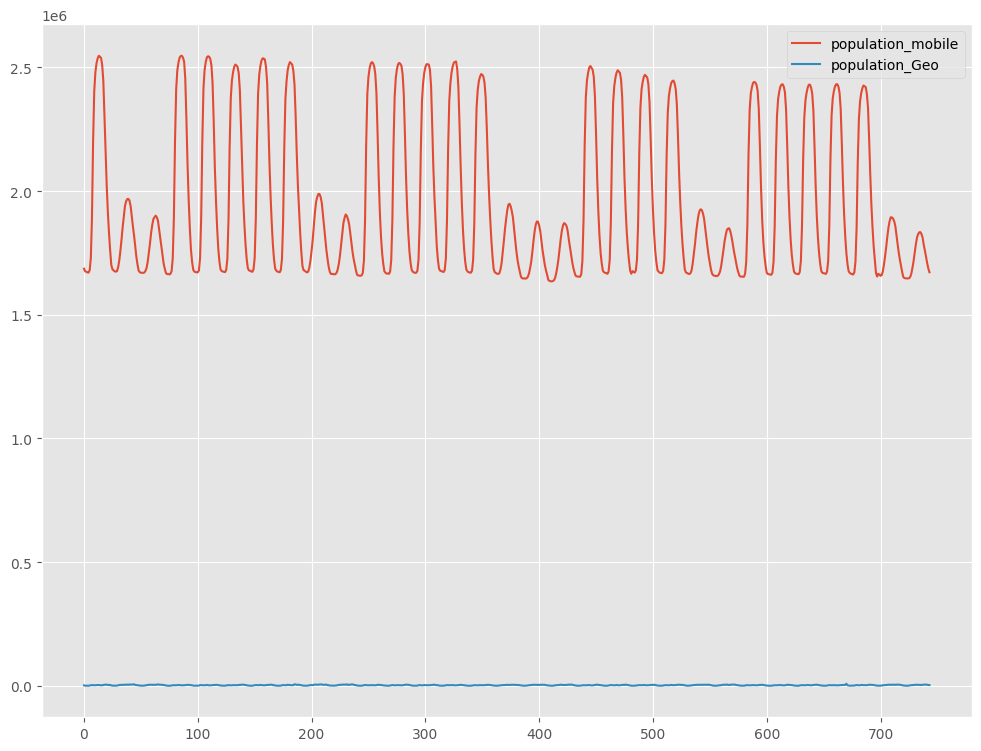

In [47]:
df.plot()

In [48]:
# Augmented Dickey-Fuller 単位根検定（帰無仮説：単位根がある）
ct_results = adfuller(df['population_mobile'],regression='ct')  #対立仮説：定数項＋トレンド＋定常過程
c_results = adfuller(df['population_mobile'],regression='c')    #対立仮説：定数項＋定常過程
n_results = adfuller(df['population_mobile'],regression='n')    #対立仮説：定常過程（定数項なし）
# p値
print(ct_results[1])
print(c_results[1])
print(n_results[1])

0.5092123185074653
0.24302284702133115
0.40843861614402466


In [49]:
# Augmented Dickey-Fuller 単位根検定（帰無仮説：単位根がある）
ct_results = adfuller(df['population_Geo'],regression='ct')  #対立仮説：定数項＋トレンド＋定常過程
c_results = adfuller(df['population_Geo'],regression='c')    #対立仮説：定数項＋定常過程
n_results = adfuller(df['population_Geo'],regression='n')    #対立仮説：定常過程（定数項なし）
# p値
print(ct_results[1])
print(c_results[1])
print(n_results[1])

0.03090307992525126
0.005719931978098165
0.567340818700224


In [50]:
df_diff1 = df.diff(1).dropna()

<AxesSubplot: >

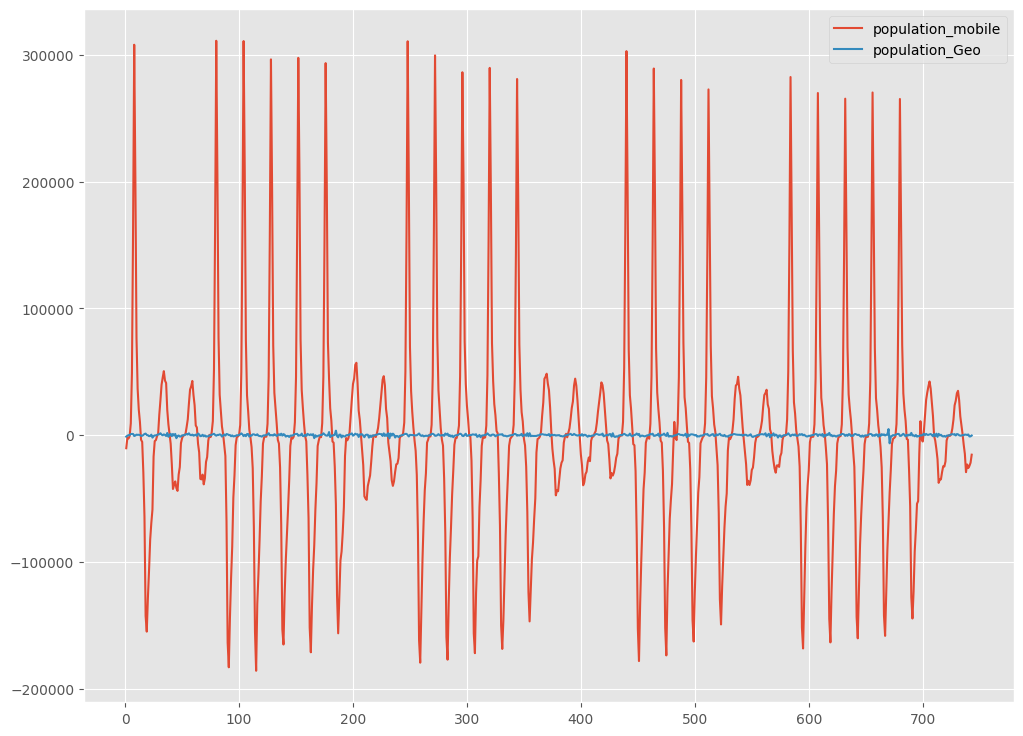

In [51]:
df_diff1.plot()

In [52]:
# Augmented Dickey-Fuller 単位根検定（帰無仮説：単位根がある）
ct_results = adfuller(df_diff1['population_mobile'],regression='ct')  #対立仮説：定数項＋トレンド＋定常過程
c_results = adfuller(df_diff1['population_mobile'],regression='c')    #対立仮説：定数項＋定常過程
n_results = adfuller(df_diff1['population_mobile'],regression='n')    #対立仮説：定常過程（定数項なし）
# p値
print(ct_results[1])
print(c_results[1])
print(n_results[1])

1.2078540680783828e-16
5.276825684336695e-19
4.571548409526104e-19


In [53]:
# Augmented Dickey-Fuller 単位根検定（帰無仮説：単位根がある）
ct_results = adfuller(df_diff1['population_Geo'],regression='ct')  #対立仮説：定数項＋トレンド＋定常過程
c_results = adfuller(df_diff1['population_Geo'],regression='c')    #対立仮説：定数項＋定常過程
n_results = adfuller(df_diff1['population_Geo'],regression='n')    #対立仮説：定常過程（定数項なし）
# p値
print(ct_results[1])
print(c_results[1])
print(n_results[1])

0.0
0.0
0.0


In [60]:
# データフレームを配列へ変換
x = df_diff1.to_numpy()
# 最大のラグ数
maxlags = 200
# モデルのインスタンス生成
model = VAR(x)
# 最適なラグの探索
lag = model.select_order(maxlags).selected_orders
print('最適なラグ：',lag['aic'],'\n')
# モデルの学習
results = model.fit(lag['aic'])
print(results.summary())

最適なラグ： 196 

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 21, Feb, 2023
Time:                     17:34:29
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    37.7157
Nobs:                     547.000    HQIC:                   33.9482
Log likelihood:          -9389.92    FPE:                1.03907e+14
AIC:                      31.5305    Det(Omega_mle):     3.51854e+13
--------------------------------------------------------------------
Results for equation y1
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
const        -126.513608       639.080535           -0.198           0.843
L1.y1           1.105058         0.080677           13.697           0.000
L1.y2           3.866655         2.303445            1.679           0.093

In [61]:
test_results = results.test_causality(causing=0, caused=1)
test_results.pvalue #p値

0.0021272120102583197

In [62]:
test_results = results.test_causality(causing=1, caused=0)
test_results.pvalue #p値

0.3847978402208427

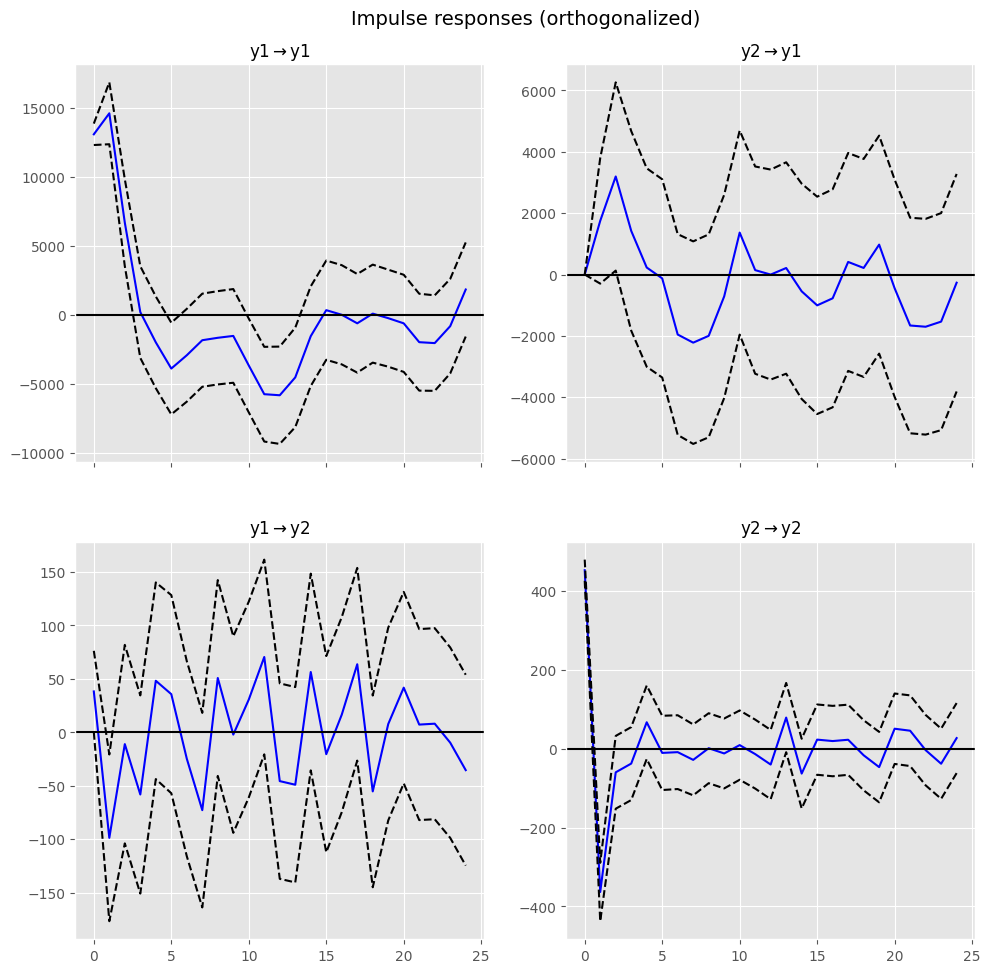

In [67]:
# (直行化)インパルス応答関数
period = 24
irf = results.irf(period)
irf.plot(orth=True)
plt.show()

population_mobile -> population_Geo 	 0.0021272120102583197
population_Geo -> population_mobile 	 0.3847978402208427


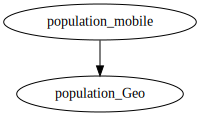

In [64]:
#
# グレンジャー因果の検定と有向グラフの描写
#
# 有向グラフのインスタンスの生成
graph = Digraph()
# グラフにノードを追加
for i in range(len(df.columns)):
    graph.node(df.columns[i])
# 因果を検定し有意なとき線を引く
for i in range(len(df.columns)):
    for j in range(len(df.columns)):
        if i != j :
            #因果の検定
            test_results = results.test_causality(causing=i, caused=j) 
            #p値
            test_results.pvalue
            #検定結果の出力
            print(df.columns[i],'->',df.columns[j],'\t',test_results.pvalue)
            #p値が0.05未満のとき線を追加
            if test_results.pvalue < 0.05:
                graph.edge(df.columns[i], df.columns[j])
            
# 有向グラフを表示
graph

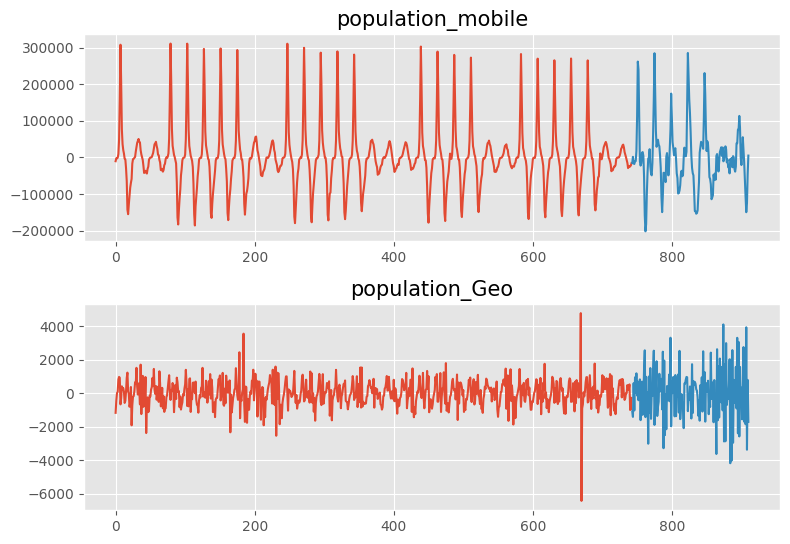

In [66]:
model_result = model.fit(lag['aic'])
steps = 168
result = model_result.forecast(model_result.endog, steps=steps)

fig = plt.figure(i, figsize=(8, 8))
for i, variable_name in enumerate(['population_mobile', 'population_Geo']):
    
    ax = fig.add_subplot(3, 1, i+1)
    y = model_result.endog[:, i]
    ax.plot(
        np.arange(len(y)),
        y
    )
    ax.plot(
        np.arange(len(y), len(y)+steps),
        result[:, i]
    )
    ax.set_title(variable_name, size=15)
    
fig.tight_layout()